# Notebook 02

Executive Summary - TBD

# 1. Imports

In [29]:
from pathlib import Path
import pandas as pd
from longevity_prediction.utils.notebook_setup import setup_notebook, resolve_project_path
from sklearn.model_selection import train_test_split
from longevity_prediction.utils.evaluation import evaluate_regression_metrics_df
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
import joblib

# 2. Settings / Configuration

In [2]:
setup_notebook(seed=42)

# 3. Loading data

In [3]:
df_clean = pd.read_csv(resolve_project_path("data", "processed", "life_expectancy_cleaned.csv"))

In [4]:
df_clean.head()

,country,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b_vaccination,measles,overweight_prevalence,...,polio_vaccination,total_expenditure,diphtheria_vaccination,hiv_aids,gdp,thinness_10_19_years,thinness_5_9_years,income_composition_of_resources,schooling,is_developed
0,Afghanistan,2015,65.0,263.0,62.0,0.01,71.279624,65.0,1154,19.1,...,6.0,8.16,65.0,0.1,584.259210,17.2,17.3,0.479,10.1,0
1,Afghanistan,2014,59.9,271.0,64.0,0.01,73.523582,62.0,492,18.6,...,58.0,8.18,62.0,0.1,612.696514,17.5,17.5,0.476,10.0,0
2,Afghanistan,2013,59.9,268.0,66.0,0.01,73.219243,64.0,430,18.1,...,62.0,8.13,64.0,0.1,631.744976,17.7,17.7,0.470,9.9,0
3,Afghanistan,2012,59.5,272.0,69.0,0.01,78.184215,67.0,2787,17.6,...,67.0,8.52,67.0,0.1,669.959000,17.9,18.0,0.463,9.8,0
4,Afghanistan,2011,59.2,275.0,71.0,0.01,7.097109,68.0,3013,17.2,...,68.0,7.87,68.0,0.1,63.537231,18.2,18.2,0.454,9.5,0


In [5]:
df_clean.columns

Index(['country', 'year', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure',
       'hepatitis_b_vaccination', 'measles', 'overweight_prevalence',
       'under_five_deaths', 'polio_vaccination', 'total_expenditure',
       'diphtheria_vaccination', 'hiv_aids', 'gdp', 'thinness_10_19_years',
       'thinness_5_9_years', 'income_composition_of_resources', 'schooling',
       'is_developed'],
      dtype='object')

# 4. Defining predictors and target

In [6]:
target_var = "life_expectancy"
y = df_clean[target_var]
X = df_clean.drop(columns=[target_var, 'country'])

# 5. Train/test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6. Baseline Model Implementation

In [8]:
reference_model = LinearRegression()

In [9]:
reference_model.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [10]:
y_pred_train = reference_model.predict(X_train)
y_pred_test = reference_model.predict(X_test)

# 7. Performance Evaluation

In [11]:
train_metrics = evaluate_regression_metrics_df(y_train, y_pred_train)
display(train_metrics)

,Metric,Value
0,MSE,12.1200
1,RMSE,3.4814
2,MAE,2.5088
3,MAPE [%],3.8567
4,RMSPE [%],5.7677
5,R²,0.8678
6,Pearson correlation,0.9316


In [12]:
test_metrics = evaluate_regression_metrics_df(y_test, y_pred_test)
display(test_metrics)

,Metric,Value
0,MSE,12.7426
1,RMSE,3.5697
2,MAE,2.5176
3,MAPE [%],3.8718
4,RMSPE [%],5.9447
5,R²,0.8527
6,Pearson correlation,0.9241


# 8. Model Exploration

In [13]:
models = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "GBR": GradientBoostingRegressor(random_state=42)
} 

In [14]:
comparison_results = []

In [15]:
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    metrics_df = evaluate_regression_metrics_df(y_test, predictions).copy()    
    metrics_df['model_name'] = name
    comparison_results.append(metrics_df)

In [17]:
comparison_df = pd.concat(comparison_results, ignore_index=True)
leaderboard = comparison_df.pivot(index='model_name', columns='Metric', values='Value')

In [18]:
display(leaderboard)

Metric,MAE,MAPE [%],MSE,Pearson correlation,RMSE,RMSPE [%],R²
model_name,,,,,,,
GBR,1.4790,2.1952,4.4466,0.9740,2.1087,3.1991,0.9486
Lasso,2.9108,4.4599,15.6736,0.9050,3.9590,6.5404,0.8188
RandomForest,1.0183,1.5397,2.6637,0.9846,1.6321,2.5525,0.9692
Ridge,2.5249,3.8877,12.6672,0.9243,3.5591,5.9380,0.8536
XGBoost,1.1158,1.6724,2.8417,0.9836,1.6857,2.5968,0.9671


⚠️ Audit Required: Tree-based models (RF/XGB) shows an unexpected jump to 97% R². Before proceeding with data transforms, a verification this isn't due to data leakage or extreme overfitting is necessary.

# 9. Model Validation & Integrity Audit

Focusing on RandomForest as the top-performing candidate

In [19]:
importances = pd.Series(
    models['RandomForest'].feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False)

In [20]:
print("Top 10 Features by Importance:")
print(importances.head(10))

Top 10 Features by Importance:
hiv_aids                           0.586292
income_composition_of_resources    0.220502
adult_mortality                    0.099460
overweight_prevalence              0.017450
under_five_deaths                  0.013294
alcohol                            0.007198
year                               0.006815
thinness_5_9_years                 0.006461
total_expenditure                  0.006411
schooling                          0.006348
dtype: float64


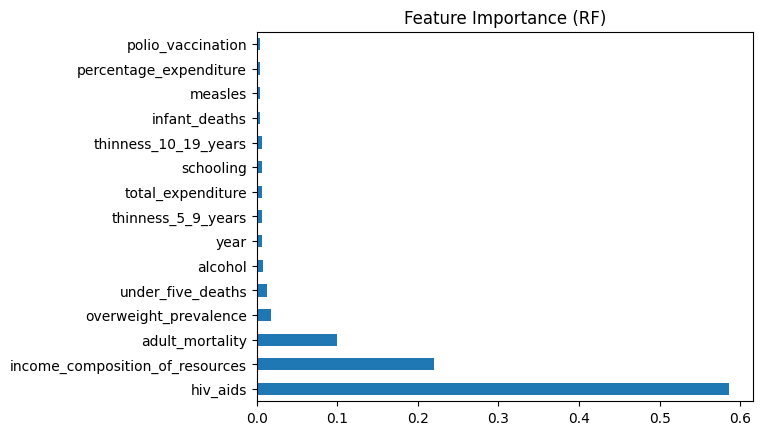

In [24]:
importances.head(15).plot(kind='barh', title='Feature Importance (RF)')
plt.show()

overfitting checks

In [25]:
train_preds = models['RandomForest'].predict(X_train)
test_preds = models['RandomForest'].predict(X_test)

In [27]:
print(f"Train R2: {r2_score(y_train, train_preds):.4f}")
print(f"Test R2:  {r2_score(y_test, test_preds):.4f}")

Train R2: 0.9949
Test R2:  0.9692


In [30]:
cv_scores = cross_val_score(models['RandomForest'], X, y, cv=5, scoring='r2')

print(f"CV R2 Scores: {cv_scores}")
print(f"Mean R2: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

CV R2 Scores: [0.94298146 0.86585335 0.9193469  0.89753215 0.91535006]
Mean R2: 0.9082 (+/- 0.0513)


# 9. Exporting model

In [39]:
baseline_path = Path("../models/baseline_v1")

In [ ]:
joblib.dump(reference_model, baseline_path / "baseline_model.pkl")

['..\\models\\baseline_v1\\baseline_model.pkl']

In [32]:
train_metrics.to_csv('../models/baseline_v1/train_metrics.csv', index=False)

In [33]:
test_metrics.to_csv('../models/baseline_v1/test_metrics.csv', index=False)

In [34]:
X_test.to_csv('../models/baseline_v1/test_data_used.csv', index=False)

In [38]:
features_df = pd.DataFrame(X.columns, columns=['feature_name'])
features_df.to_csv('../models/baseline_v1/features.csv', index=False)

In [41]:
comparison_df.to_csv('../models/initial_search/comparison_metrics.csv')